## Analyze Dataset Performance

As described in the README's RIP example scripts, the user can set `--debug_collect_dataset_stats=True` and cache statistics and performance over the training and validation datasets to file.

This script provides some analysis utilities for plotting and understanding a model's performance on various subsets of the data.

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from collections import defaultdict

In [2]:
# full_model_name takes a format such as rip-bc-k_3-plan_ma-scene_ma
# for a RIP ensemble with the Behavioral Cloning backbone, 3 ensemble members, and
# model averaging (mean) aggregation over per-plan and per-scene confidence scores.
# For more details, see `sdc.oatomobile.torch.baselines.robust_imitative_planning.py`.

dir_metadata_cache = '/path/to/metadata_cache/full_model_name'

# Model Backbone: "BC" or "DIM"
model_backbone = 'DIM'
# model_backbone = 'BC'

In [3]:
with open(os.path.join(dir_metadata_cache, 'request.tsv')) as f:
    request_df = pd.read_csv(f, sep='\t')
    
with open(os.path.join(dir_metadata_cache, 'scene.tsv')) as f:
    scene_df = pd.read_csv(f, sep='\t')

In [24]:
# Join prediction_request_df and scene_df on scene_id
merged_df = pd.merge(request_df, scene_df, on=['scene_ids'])

In [26]:
merged_df = merged_df[merged_df['dataset_key_y'].isin([
    'ood__validation', 'moscow__validation'])]

In [6]:
merged_df.head()

,pred_request_confidence_scores,request_ids,kMoveLeft,kMoveRight,kMoveForward,kMoveBack,kAcceleration,kDeceleration,kUniform,kStopping,...,track__TelAviv,sun_phase__kAstronomicalNight,sun_phase__kTwilight,sun_phase__kDaylight,precipitation__kNoPrecipitation,precipitation__kRain,precipitation__kSleet,precipitation__kSnow,dataset_key_y,run_datetime_y
0,96.470375,224,False,False,False,False,False,False,True,False,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:26:03.657725
1,93.516670,225,False,False,False,False,True,False,True,False,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:26:03.657725
2,77.778940,227,False,False,False,False,True,False,True,False,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:26:03.657725
3,79.958300,234,False,False,False,False,False,False,True,False,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:26:03.657725
4,102.637215,240,False,False,False,False,False,False,True,True,...,0,1,0,0,-1,-1,-1,-1,moscow__validation,2021-06-30 21:26:03.657725


In [7]:
list(merged_df.columns)

['pred_request_confidence_scores',
 'request_ids',
 'kMoveLeft',
 'kMoveRight',
 'kMoveForward',
 'kMoveBack',
 'kAcceleration',
 'kDeceleration',
 'kUniform',
 'kStopping',
 'kStarting',
 'kStationary',
 'weightedADE',
 'weightedFDE',
 'avgADE',
 'avgFDE',
 'top1ADE',
 'top1FDE',
 'minADE',
 'minFDE',
 'scene_ids',
 'dataset_key_x',
 'run_datetime_x',
 'num_vehicles',
 'day_time__kNight',
 'day_time__kMorning',
 'day_time__kAfternoon',
 'day_time__kEvening',
 'season__kWinter',
 'season__kSpring',
 'season__kSummer',
 'season__kAutumn',
 'track__Moscow',
 'track__Skolkovo',
 'track__Innopolis',
 'track__AnnArbor',
 'track__Modiin',
 'track__TelAviv',
 'sun_phase__kAstronomicalNight',
 'sun_phase__kTwilight',
 'sun_phase__kDaylight',
 'precipitation__kNoPrecipitation',
 'precipitation__kRain',
 'precipitation__kSleet',
 'precipitation__kSnow',
 'dataset_key_y',
 'run_datetime_y']

In [27]:
# All datasets for which a prediction was collected
dataset_keys = set(merged_df['dataset_key_y']); dataset_keys

{'moscow__validation', 'ood__validation'}

In [9]:
moscow_val_rows = merged_df[merged_df['dataset_key_y'] == 'moscow__validation']
ood_val_rows = merged_df[merged_df['dataset_key_y'] == 'ood__validation']

In [10]:
# Average confidence on the Moscow and OOD validation sets, respectively
moscow_val_rows.pred_request_confidence_scores.mean(), ood_val_rows.pred_request_confidence_scores.mean()

(53.18380762326993, 51.953120872693404)

In [11]:
# Average minADE on the same validation sets
moscow_val_rows['minADE'].mean(), ood_val_rows['minADE'].mean()

(0.7205887193223128, 0.7879897681322356)

## Fbeta Retention Plots

In [12]:
# Get an idea of a reasonable cutoff for an "acceptable prediction" on our metric of choice.
# We achieve a weightedADE on the in-distribution dev/eval datasets near 1, 
# and hence fix the threshold to 1 for our metrics.
error_col = 'weightedADE'
np.mean(moscow_val_rows['weightedADE'])

1.3989488529673109

(array([7.6280e+03, 1.2959e+04, 1.1012e+04, 1.0019e+04, 9.8990e+03,
        1.0039e+04, 1.0453e+04, 1.0392e+04, 1.0545e+04, 1.0153e+04,
        9.5330e+03, 9.0270e+03, 8.5730e+03, 7.8450e+03, 7.2220e+03,
        6.4560e+03, 5.9670e+03, 5.5210e+03, 5.0100e+03, 4.5370e+03,
        4.1650e+03, 3.8760e+03, 3.4850e+03, 3.2030e+03, 2.8680e+03,
        2.6870e+03, 2.5120e+03, 2.3800e+03, 2.1760e+03, 1.9900e+03,
        1.8330e+03, 1.8040e+03, 1.6050e+03, 1.5830e+03, 1.4860e+03,
        1.4220e+03, 1.2470e+03, 1.2930e+03, 1.1910e+03, 1.1530e+03,
        1.1950e+03, 1.0510e+03, 1.1080e+03, 1.0210e+03, 1.0030e+03,
        9.3200e+02, 9.7700e+02, 9.5900e+02, 9.3400e+02, 8.9100e+02,
        9.1300e+02, 8.9500e+02, 8.8300e+02, 8.1300e+02, 8.1800e+02,
        7.7700e+02, 8.2000e+02, 8.3600e+02, 7.9300e+02, 7.7300e+02,
        7.6100e+02, 7.6800e+02, 7.7500e+02, 8.1300e+02, 8.0300e+02,
        7.9400e+02, 8.1700e+02, 7.8000e+02, 7.8900e+02, 7.6200e+02,
        7.8600e+02, 7.8700e+02, 7.5900e+02, 7.42

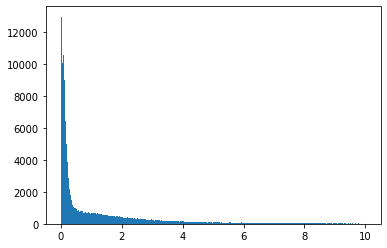

In [13]:
# Plot histogram of weightedADE values for the Moscow development dataset, excluding outliers >= 10
plt.hist(moscow_val_rows['weightedADE'][moscow_val_rows['weightedADE'] < 10], bins=1000)

In [14]:
# F1 metrics and retention plots
from sdc.assessment import f_beta_metrics

datasets = {
    'moscow__validation': moscow_val_rows,
    'ood_validation': ood_val_rows
}

# To compute metrics over all dev datapoints
# all_dev_rows = merged_df[
#     (merged_df['dataset_key_y'] == 'moscow__validation') | (merged_df['dataset_key_y'] == 'ood__validation')]
# datasets = {
#     'all__dev': all_dev_rows
# }

def get_dataset_to_f1_retention_results(datasets, metric_name): 
    dataset_key_to_f1_retention = {}

    for dataset_key, data_rows in datasets.items():
        errors = data_rows[metric_name].to_numpy()
        uncertainty = -(data_rows['pred_request_confidence_scores'].to_numpy())
        threshold = 1
        beta = 1

        # Using our model's uncertainty values
        actual_retention_results = f_beta_metrics(
            errors=errors, uncertainty=uncertainty, threshold=threshold, beta=beta)

        # Using randomly shuffled uncertainty values (uninformative uncertainty)
        shuffled_uncertainty = uncertainty.copy()
        np.random.shuffle(shuffled_uncertainty)
        random_retention_results = f_beta_metrics(
            errors=errors, uncertainty=shuffled_uncertainty, threshold=threshold, beta=beta)

        # Using optimal uncertainty values (i.e., sorted by error)
        opt_retention_results = f_beta_metrics(
            errors=errors, uncertainty=errors, threshold=threshold, beta=beta)

        results_dict = {
            'Baseline': actual_retention_results,
            'Random': random_retention_results,
            'Optimal': opt_retention_results
        }
    
        dataset_key_to_f1_retention[dataset_key] = results_dict
        
    return dataset_key_to_f1_retention

dataset_key_to_f1_retention = get_dataset_to_f1_retention_results(
    datasets=datasets, metric_name=error_col)

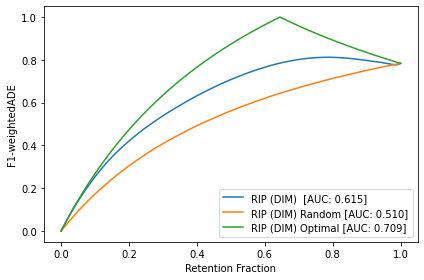

Saved to path /scratch-ssd/neiand/sdc/f_beta_plots/DIM__moscow__validation.pdf.


In [15]:
import matplotlib.pyplot as plt

# Plot F1 results
fbeta_plot_path = '/path/to/fbeta_plots'
os.makedirs(fbeta_plot_path, exist_ok=True)

def plot_fbeta_retention_curve(results_dict, dataset_name, metric_name):
    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    markers = ['o', 'D', 's', '8', '^', '*']

    for b, (baseline, retention_results) in enumerate(results_dict.items()):
        f_auc, f95, retention_arr = retention_results
            
        if baseline == 'Baseline':
            baseline = ''
            
        x = np.arange(len(retention_arr))
        x = x / len(retention_arr)
        ax.plot(
            x,
            retention_arr,
            label=f'RIP ({model_backbone}) {baseline} [AUC: {f_auc:.3f}]',
            color=colors[b % len(colors)]
        )
        
        ax.set(xlabel='Retention Fraction',
               ylabel=f'F1-{metric_name}')
        ax.legend()
        fig.tight_layout()
        
    plt.show()
    metric_plot_file_path = os.path.join(fbeta_plot_path, f'{model_backbone}__{dataset_name}.pdf')
    fig.savefig(metric_plot_file_path, transparent=True, dpi=300, format='pdf')
    print(f'Saved to path {metric_plot_file_path}.')

  
dataset_key = 'moscow__validation'
# dataset_key = 'all__dev'
plot_fbeta_retention_curve(dataset_key_to_f1_retention[dataset_key], dataset_key, error_col)

## Aggregate Metrics on Subsets of Data

In [17]:
# Because we have cached per--prediction request losses for each metric, we can easily compute
# losses for arbitrary subsets of the data, e.g., joint losses for in-distribution and 
# distributionally shifted development sets.

# e.g., compute all metrics reported in whitepaper over the Full Dev dataset

metrics = ['minADE', 'weightedADE', 'minFDE', 'weightedFDE']
all_dev_rows = merged_df[
    (merged_df['dataset_key_y'] == 'moscow__validation') | (merged_df['dataset_key_y'] == 'ood__validation')]
print(len(all_dev_rows))
for metric in metrics:
    print(metric, all_dev_rows[metric].mean())

465421
minADE 0.7286505579290787
weightedADE 1.4074258229777452
minFDE 1.5135569556713067
weightedFDE 3.2253384047218856


In [18]:
# Fbeta metrics
all_dev_dataset = {
    'all_dev': all_dev_rows
}
all_dev_fbeta_metrics = get_dataset_to_f1_retention_results(
    all_dev_dataset, error_col)['all_dev']
all_dev_fbeta_metrics['Baseline']

(0.6186058759215495,
 0.794762362430906,
 array([0.00000000e+00, 6.56105554e-06, 1.31220680e-05, ...,
        7.91501947e-01, 7.91503516e-01, 7.91505085e-01]))

### Retention on Metric Columns (e.g., weightedADE)

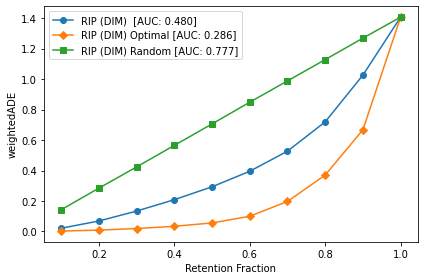

Saved to path /scratch-ssd/neiand/sdc/retention_plots/DIM__all__dev.pdf.


In [19]:
# See sdc/metrics.py for the full retention plot utilities.
from collections import defaultdict

retention_thresholds = [
    0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
use_oracle = True

retention_plot_path = '/path/to/retention_plots'
os.makedirs(retention_plot_path, exist_ok=True)

def get_retention_curve(sorted_confidences, losses, retention_thresholds, use_oracle):
    metrics_dict = defaultdict(float)
    retention_threshold_to_n_points = {}
    M = len(losses)
    
    # Compute metric for range of retention thresholds
    for retention_threshold in retention_thresholds:
        retain_bool_mask = np.zeros_like(
            sorted_confidences)
        n_retained_points = int(M * retention_threshold)
        indices_to_retain = sorted_confidences[
            :n_retained_points]

        # These are used for normalization
        # We can reflect our use of the oracle on all non-retained points
        # (importantly, assuming we are using ADE/FDE) by just normalizing
        # over all datapoints (since the losses at non-retained points
        # would be 0).
        if use_oracle:
            n_retained_points = M
        retention_threshold_to_n_points[
            retention_threshold] = n_retained_points
        retain_bool_mask[indices_to_retain] = 1
        retain_bool_mask = retain_bool_mask.astype(np.bool_)

        counter = 0

        # Do this instead of enumerate to handle np.ndarray
        for datapoint_index in range(M):
            if not retain_bool_mask[datapoint_index]:
                continue
            else:
                counter += 1

            prediction_loss = losses[datapoint_index]
            metrics_dict[retention_threshold] += prediction_loss

    retention_values = []
    for retention_threshold in retention_thresholds:
        loss = metrics_dict[retention_threshold]
        retention_values.append(
            loss / retention_threshold_to_n_points[retention_threshold])
        
    # Compute AUC and plot retention curve
    auc = np.mean(retention_values)
    
    return auc, retention_values


def plot_retention_curve(chosen_rows, dataset_name):
    losses = chosen_rows[error_col].to_numpy()
    M = len(losses)

    methods = ['Baseline', 'Optimal', 'Random']
    aucs_retention_curves = []

    # Get baseline results
    sorted_pred_request_confidences = np.argsort(
        chosen_rows['pred_request_confidence_scores'].to_numpy())[::-1]
    aucs_retention_curves.append(get_retention_curve(
        sorted_confidences=sorted_pred_request_confidences, losses=losses, 
        retention_thresholds=retention_thresholds, use_oracle=use_oracle))

    # Optimal results
    aucs_retention_curves.append(get_retention_curve(
        sorted_confidences=np.argsort(losses), losses=losses, 
        retention_thresholds=retention_thresholds, use_oracle=use_oracle))

    # Random results
    random_indices = np.arange(M)
    np.random.shuffle(random_indices)
    aucs_retention_curves.append(get_retention_curve(
        sorted_confidences=random_indices, losses=losses, 
        retention_thresholds=retention_thresholds, use_oracle=use_oracle))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    markers = ['o', 'D', 's', '8', '^', '*']

    fig, ax = plt.subplots()
    for b, (baseline, (auc, retention_values)) in enumerate(zip(methods, aucs_retention_curves)):
        if baseline == 'Baseline':
            baseline = ''
        ax.plot(
            retention_thresholds,
            retention_values,
            label=f'RIP ({model_backbone}) {baseline} [AUC: {auc:.3f}]',
            color=colors[b % len(colors)],
            marker=markers[b % len(markers)]
        )

    ax.set(xlabel='Retention Fraction', ylabel=error_col)
    ax.legend()
    fig.tight_layout()
    plt.show()
    ret_plot_file_path = os.path.join(retention_plot_path, f'{model_backbone}__{dataset_name}.pdf')
    fig.savefig(ret_plot_file_path, transparent=True, dpi=300, format='pdf')
    print(f'Saved to path {ret_plot_file_path}.')
    
plot_retention_curve(chosen_rows=all_dev_rows, dataset_name='all__dev')

### Dataset Structure Analysis
Consider on which splits of the data the model performs better.

<Figure size 1440x720 with 0 Axes>

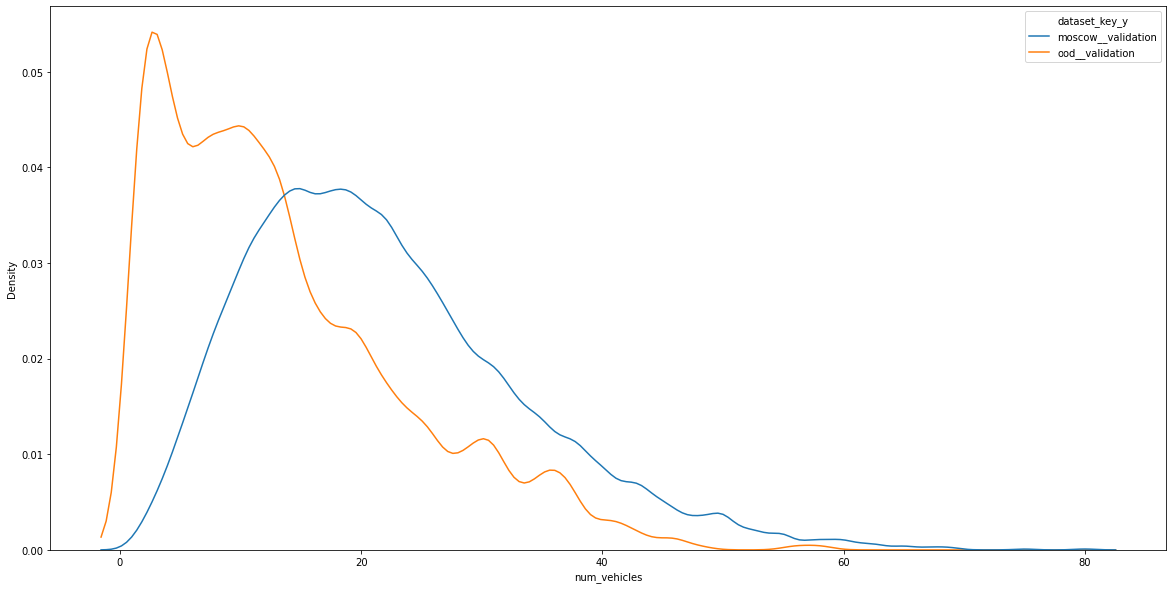

<Figure size 1440x720 with 0 Axes>

In [20]:
# Distribution of number of vehicles in each dataset
plt.rcParams["figure.figsize"] = (20,10)

sns.kdeplot(
    data=merged_df, x="num_vehicles", hue="dataset_key_y",
    common_norm=False, common_grid=True)
plt.figure(figsize=(20,10))

### Tag Groups

In [28]:
TRAJECTORY_TAGS = [
 'kMoveLeft',
 'kMoveRight',
 'kMoveForward',
 'kMoveBack',
 'kAcceleration',
 'kDeceleration',
 'kUniform',
 'kStopping',
 'kStarting',
 'kStationary'
]
TIMES_OF_DAY = [
 'day_time__kNight',
 'day_time__kMorning',
 'day_time__kAfternoon',
 'day_time__kEvening',
]
SEASONS = [
 'season__kWinter',
 'season__kSpring',
 'season__kSummer',
 'season__kAutumn',
]
CITY = [
 'track__Moscow',
 'track__Skolkovo',
 'track__Innopolis',
 'track__AnnArbor',
 'track__Modiin',
 'track__TelAviv'
]

In [29]:
# For each dataset, bucket a metric by percentile (e.g., into deciles). 
# Plot the distribution of various tags within each bucket.

def tag_heatmap(metric, tags, dataset_key, n_buckets=10, bucket_normalize=True):
    dataset_df = merged_df[merged_df['dataset_key_y'] == dataset_key]
    
    # Bucket rows based on metric column
    dataset_df[f'{metric}_decile'] = pd.qcut(dataset_df[metric], q=n_buckets, labels=range(n_buckets))
    print(f'Min {metric} in deciles:')
    print(dataset_df.groupby(f'{metric}_decile')[metric].mean())
    print(dataset_df.groupby(f'{metric}_decile')[metric].count())
    
    # Group by buckets
    percentiles = [val / 10 for val in range(n_buckets)]
    values = np.zeros((len(tags), len(percentiles)))
    
    dataset_n_rows = len(dataset_df)
    
    if bucket_normalize:
        for j, perc in enumerate(range(n_buckets)):
            perc_df = dataset_df[dataset_df[f'{metric}_decile'] == perc]
            total_perc_rows = len(perc_df)
            print(total_perc_rows)
            for i, tag in enumerate(tags):
                tag_df = perc_df[perc_df[tag] == 1]
                values[i, j] = len(tag_df) / total_perc_rows
    else:
        for i, tag in enumerate(tags):
            tag_df = dataset_df[dataset_df[tag] == 1]
            counts = tag_df.value_counts(subset=[f'{metric}_decile']).to_numpy()[::-1]
            norm_counts = counts / counts.sum()
            values[i, :] = norm_counts

    values = np.stack(values)
    fig, ax = plt.subplots()
    im = ax.imshow(values, cmap="YlGn")
    cbar = ax.figure.colorbar(im, ax=ax)
    
    # We want to show all the ticks
    ax.set_xticks(np.arange(len(percentiles)))
    ax.set_yticks(np.arange(len(tags)))
    
    # and label them with the respective list entries
    ax.set_xticklabels(percentiles)
    ax.set_yticklabels(tags)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(tags)):
        for j in range(len(percentiles)):
            text = ax.text(j, i, f'{values[i, j]:.2}',
                           ha="center", va="center", color="black")

    if bucket_normalize:
        ax.set_title(f"Proportion of {metric} Decile with Given Tag")
    else:
        ax.set_title(f'Proportion of Given Tag Falling in Each {metric} Decile')
        
    fig.tight_layout()
    plt.show()

<ipython-input-29-f9614de60dcd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df[f'{metric}_decile'] = pd.qcut(dataset_df[metric], q=n_buckets, labels=range(n_buckets))
<ipython-input-29-f9614de60dcd>:31: RuntimeWarning: invalid value encountered in true_divide
  norm_counts = counts / counts.sum()


Min minADE in deciles:
minADE_decile
0    0.034861
1    0.057850
2    0.072871
3    0.089564
4    0.112268
5    0.149193
6    0.247059
7    0.659103
8    1.529195
9    4.927819
Name: minADE, dtype: float64
minADE_decile
0    5567
1    5567
2    5567
3    5567
4    5567
5    5566
6    5567
7    5567
8    5567
9    5567
Name: minADE, dtype: int64


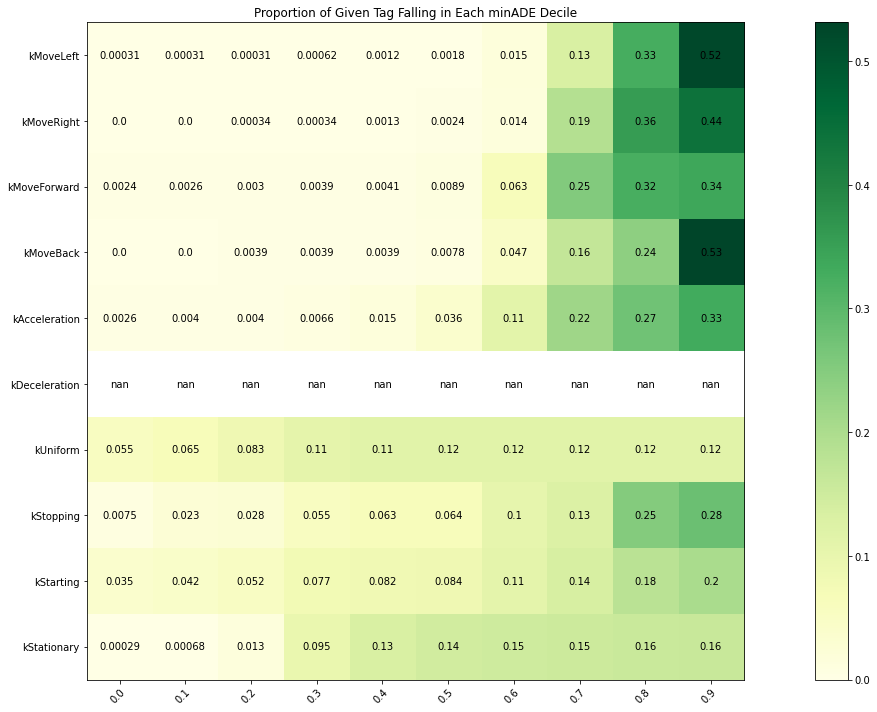

In [30]:
# Example takeaway: the majority of instances of the kMoveBack tag (a challenging trajectory type)
# occurs in the decile of predictions with the worst (highest) minADE
tag_heatmap('minADE', TRAJECTORY_TAGS, dataset_key='ood__validation', n_buckets=10, bucket_normalize=False)

### Trajectory Tag Plots
Note that trajectory tags are not mutually exclusive. We report a metric of choice when fixing a given tag (e.g., `kMoveBack`) to be present or absent.

In [31]:
chosen_metric = 'minADE'

In [32]:
data = defaultdict(list)
for dataset_key in dataset_keys:
    print('\n')
    print('Computing statistics for dataset', dataset_key)
    dataset_df = merged_df[merged_df['dataset_key_y'] == dataset_key]
    for traj_tag in TRAJECTORY_TAGS:
        n_present_absent = []
        for toggle in [1, 0]:
            traj_tag_df = dataset_df[dataset_df[traj_tag] == toggle]
            perc = np.round(100 * (len(traj_tag_df) / len(dataset_df)))
            n_present_absent.append(len(traj_tag_df))
            data['dataset'].append(dataset_key)
            data['traj_tag'].append(f'{traj_tag}__{str(toggle)}')
            data['val'].append(traj_tag_df[chosen_metric].mean())
            
        print(f'{traj_tag}: Present {n_present_absent[0]} | Absent {n_present_absent[1]}')



Computing statistics for dataset ood__validation
kMoveLeft: Present 3246 | Absent 52423
kMoveRight: Present 2978 | Absent 52691
kMoveForward: Present 9513 | Absent 46156
kMoveBack: Present 256 | Absent 55413
kAcceleration: Present 11131 | Absent 44538
kDeceleration: Present 0 | Absent 55669
kUniform: Present 48354 | Absent 7315
kStopping: Present 2132 | Absent 53537
kStarting: Present 2884 | Absent 52785
kStationary: Present 33983 | Absent 21686


Computing statistics for dataset moscow__validation
kMoveLeft: Present 10127 | Absent 399625
kMoveRight: Present 13398 | Absent 396354
kMoveForward: Present 163478 | Absent 246274
kMoveBack: Present 1539 | Absent 408213
kAcceleration: Present 119816 | Absent 289936
kDeceleration: Present 0 | Absent 409752
kUniform: Present 331303 | Absent 78449
kStopping: Present 22760 | Absent 386992
kStarting: Present 33394 | Absent 376358
kStationary: Present 178064 | Absent 231688


<Figure size 1440x720 with 0 Axes>

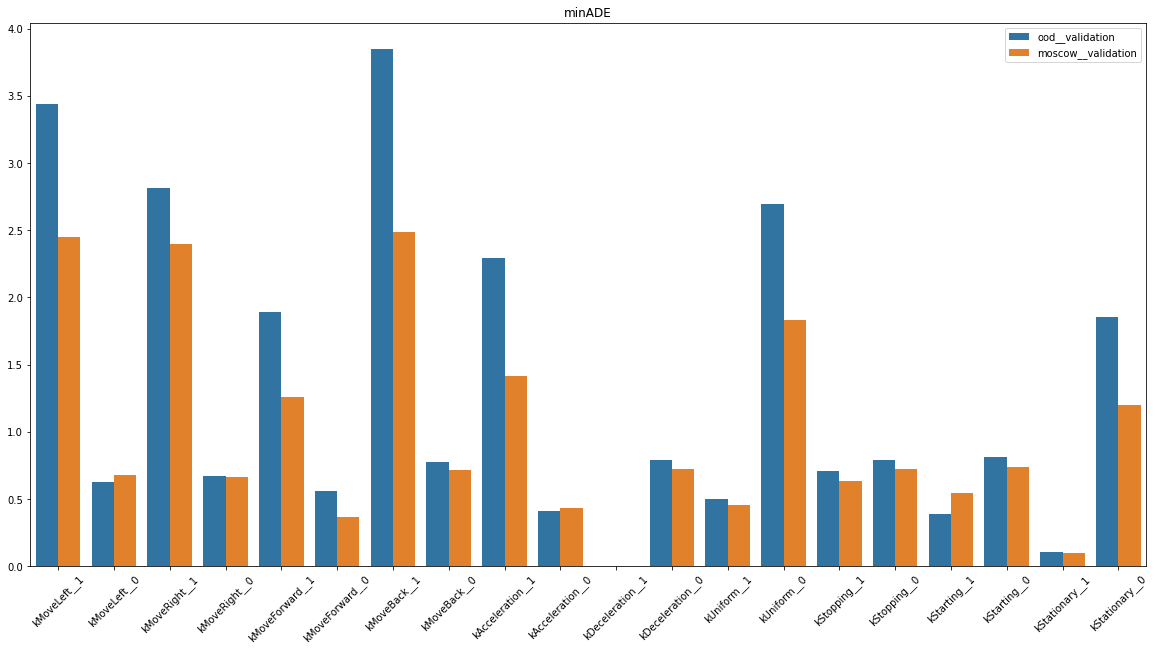

<Figure size 1440x720 with 0 Axes>

In [33]:
plt.xticks(rotation=45)
plt.title(chosen_metric)
ax = sns.barplot(x="traj_tag", y="val", hue="dataset", data=data)
plt.figure(figsize=(20,10))

## Mutually Exclusive Bar Groupings

In [34]:
def plot_mutually_exclusive_bar_groupings(metric, groups):
    data = defaultdict(list)
    for dataset_key in dataset_keys:
        print('Computing statistics for dataset', dataset_key)
        dataset_df = merged_df[merged_df['dataset_key_y'] == dataset_key]
        for group in groups:
            print(group)
            filt_df = dataset_df[dataset_df[group] == True]
            perc = np.round(100 * (len(filt_df) / len(dataset_df)))
            data['dataset'].append(dataset_key)
            data['group'].append(group)
            data['val'].append(filt_df[metric].mean())
            
    plt.title(metric)
    ax = sns.barplot(x="group", y="val", hue="dataset", data=data)
    plt.figure(figsize=(20,10))
    
metric = 'minADE'

### Times of Day

Computing statistics for dataset ood__validation
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening
Computing statistics for dataset moscow__validation
day_time__kNight
day_time__kMorning
day_time__kAfternoon
day_time__kEvening


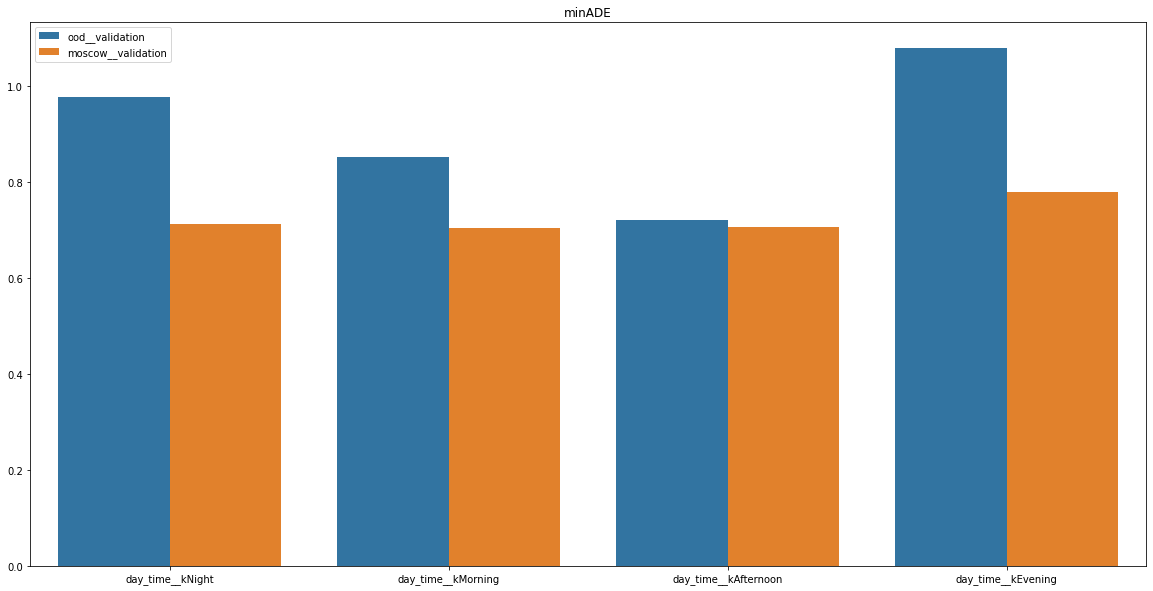

<Figure size 1440x720 with 0 Axes>

In [35]:
plot_mutually_exclusive_bar_groupings(metric=metric, groups=TIMES_OF_DAY)

### Seasons

Computing statistics for dataset ood__validation
season__kWinter
season__kSpring
season__kSummer
season__kAutumn
Computing statistics for dataset moscow__validation
season__kWinter
season__kSpring
season__kSummer
season__kAutumn


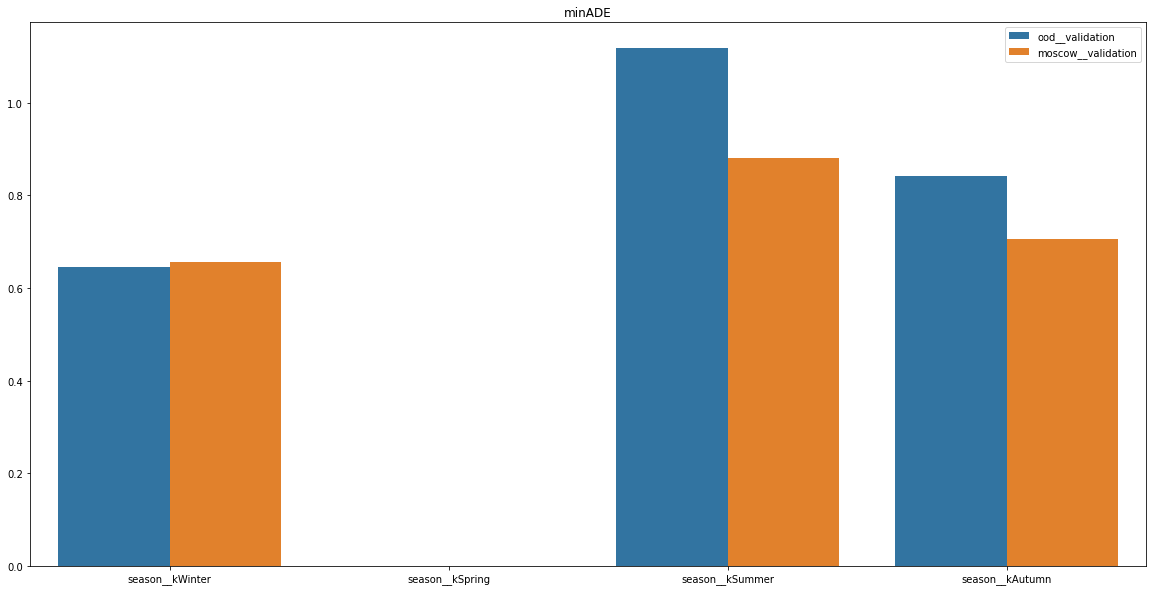

<Figure size 1440x720 with 0 Axes>

In [36]:
plot_mutually_exclusive_bar_groupings(metric=metric, groups=SEASONS)

### City

Computing statistics for dataset ood__validation
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv
Computing statistics for dataset moscow__validation
track__Moscow
track__Skolkovo
track__Innopolis
track__AnnArbor
track__Modiin
track__TelAviv


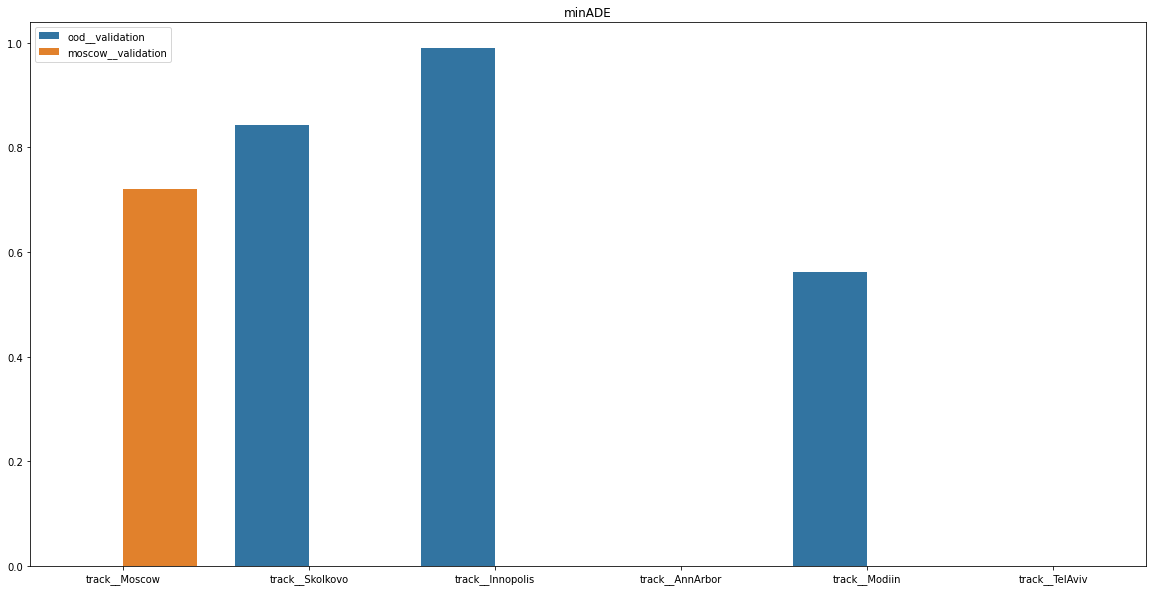

<Figure size 1440x720 with 0 Axes>

In [37]:
plot_mutually_exclusive_bar_groupings(metric=metric, groups=CITY)

### Precipitation

Computing statistics for dataset ood__validation
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow
Computing statistics for dataset moscow__validation
precipitation__kNoPrecipitation
precipitation__kRain
precipitation__kSleet
precipitation__kSnow


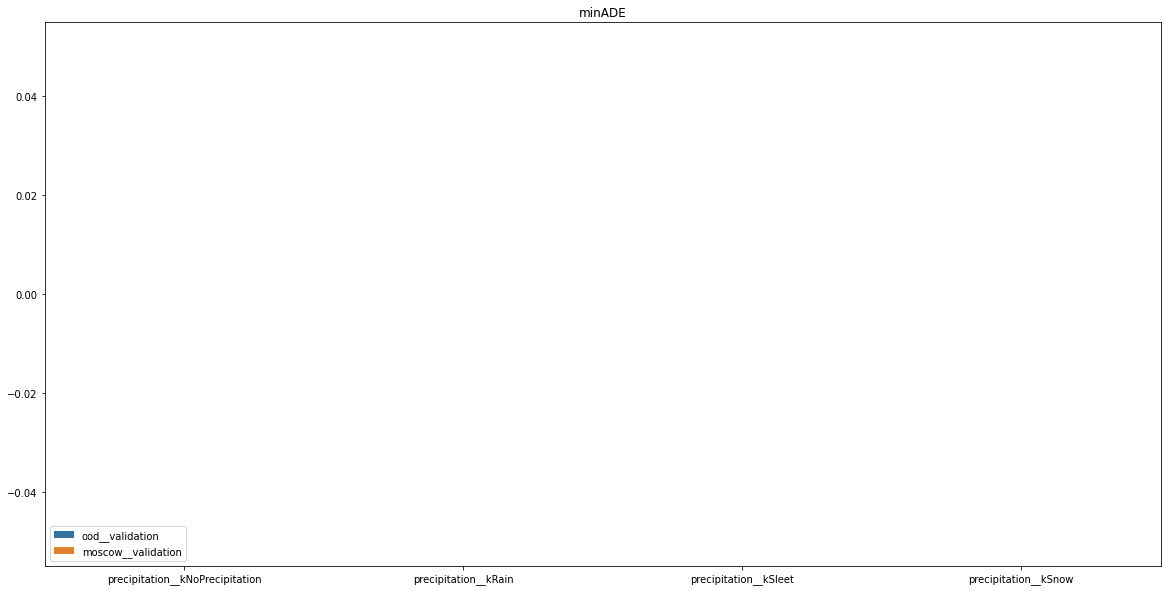

<Figure size 1440x720 with 0 Axes>

In [38]:
PRECIPITATION = [
 'precipitation__kNoPrecipitation',
 'precipitation__kRain',
 'precipitation__kSleet',
 'precipitation__kSnow',
]
plot_mutually_exclusive_bar_groupings(metric=metric, groups=PRECIPITATION)

## Confidence Quality

In [39]:
# Compute correlation of avg/minADE wrt confidence, stratified by trajectory tag
metric = 'avgADE'

for dataset_key in dataset_keys:
    for trajectory_tag in TRAJECTORY_TAGS:
        dataset_df = merged_df[(
            merged_df['dataset_key_y'] == dataset_key) &
            (merged_df[trajectory_tag] == True)]
        corr_df = dataset_df[['pred_request_confidence_scores', metric]]
        print('-----')
        print(dataset_key, trajectory_tag)
        print(corr_df.corr(method='pearson'))

-----
ood__validation kMoveLeft
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.388234
avgADE                                               -0.388234  1.000000
-----
ood__validation kMoveRight
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.325613
avgADE                                               -0.325613  1.000000
-----
ood__validation kMoveForward
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.352829
avgADE                                               -0.352829  1.000000
-----
ood__validation kMoveBack
                                pred_request_confidence_scores    avgADE
pred_request_confidence_scores                        1.000000 -0.153514
avgADE                                               -0.153514  1